# 2024-026 Differential Peak Analysis - JSB

This notebook describes steps to perform differential peak analysis of published ATAC-seq data from Scott-Browne 2016.

## Initialize Enviroment

In [16]:
# Load Libraries
library(DESeq2)
library(dplyr)
library(ggplot2)
library(tidyr)

# Load data
exp_dir     <- "/home/dalbao/2024-026-Tcf7ATAC"
nfcore_dir  <- "01_nfcore_241228"
nb_dir      <- "02_bp_notebooks"
prefix      <- "reAnalysis"                                # bp for broad peak calling settings

# Experiments to analyze
exp <- c("JSB")

# Comparisons
comp_file <- "metadata/comparisons_jsb.csv"

# Filter file
filter_file <- "241231-bp-peakFilter.txt"
# Add folder structure to filter_file
filter_file <- paste(nfcore_dir, filter_file, sep = "/")

# nf-core ATAC-seq pipeline calls peaks from two different libraries:
library     <- "merged_library"
# If library == merged_library, lib_sh is mLb
# else if it is == merged_replicates, lib_sh is mRp
lib_sh      <- ifelse(library == "merged_library", "mLb", "mRp")

# nf-core ATAC-seq pipeline calls peaks in two types, broad_peak and narrow_peak:
peak_type   <- "broad_peak"
# If peak_type == broad_peak, peak_sh is bp
peak_sh     <- ifelse(peak_type == "broad_peak", "bp", "np")

# Add peak type and date to prefix
prefix <- paste0(format(Sys.Date(), "%y%m%d"), "-", peak_sh, "-", prefix, "-", exp)

# Move to working directory
setwd(exp_dir)

In [17]:
# Load feature counts
featureCounts <- paste( nfcore_dir,
                        "/bwa/",
                        library,
                        "/macs2/",
                        peak_type,
                        "/consensus/",
                        "consensus_peaks.", lib_sh, ".clN.featureCounts.txt", sep = "")

# Load feature counts
featureCounts <- read.table(featureCounts,
                            header = TRUE)

# Remove unnecessary columns
featureCounts <- featureCounts[, -c(2:6)]

# Rename columns
sample_suffix <- paste0(".", lib_sh, ".clN.sorted.bam")
colnames(featureCounts) <- gsub(sample_suffix, "", colnames(featureCounts))

# Make intervals as row names
rownames(featureCounts) <- featureCounts$Geneid
featureCounts <- featureCounts[, -1]

# Check
head(featureCounts)

,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_1,2,0,2,0,2,1,2,0,2,1,⋯,5,4,5,4,6,3,2,4,7,7
Interval_2,2,1,10,0,0,2,2,1,2,3,⋯,8,2,5,6,10,7,9,5,7,15
Interval_3,1,1,1,0,3,1,1,0,1,2,⋯,3,2,2,2,2,1,2,5,3,5
Interval_4,1,1,2,0,0,0,0,0,0,0,⋯,4,1,4,1,3,4,1,8,0,3
Interval_5,2,1,0,0,1,2,0,0,0,1,⋯,5,4,5,4,6,1,6,7,6,6
Interval_6,3,3,1,0,1,1,0,0,5,2,⋯,10,2,2,5,0,4,3,8,5,8


In [18]:
# Load sample metadata
sampleMetadata <- read.csv("metadata/sampleMetadata.csv")

# Make sample names as row names
rownames(sampleMetadata) <- sampleMetadata$Sample
sampleMetadata <- sampleMetadata[, -1]

# Check
head(sampleMetadata)

# Make sure the observations in sampleMetadata are in the same order as the columns in featureCounts
sampleMetadata <- sampleMetadata[colnames(featureCounts), ]

# Load keep peaks file
keep <- read.table(filter_file, header = TRUE)
keep <- keep[keep$keep == TRUE, ]

# Keep only features (identified by rowname) that are in keep$interval_id
featureCounts <- featureCounts[rownames(featureCounts) %in% keep$interval_id, ]
head(featureCounts)

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
DW_WT_24h_REP2,DW,DW_WT_24h,,,REP2,24,WT,NA,
DW_RUNX3KO_0h_REP2,DW,DW_RUNX3KO_0h,,,REP2,0,RUNX3KO,NA,
DW_RUNX3KO_6h_REP1,DW,DW_RUNX3KO_6h,,,REP1,6,RUNX3KO,NA,
DW_WT_6h_REP1,DW,DW_WT_6h,,,REP1,6,WT,NA,
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,
DW_WT_0h_REP1,DW,DW_WT_0h,,,REP1,0,WT,NA,


,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,17,32,33,35,12,14,80,3,27,61,⋯,234,224,212,147,176,165,240,364,177,128
Interval_103,29,5,28,22,8,9,51,1,3,13,⋯,183,160,117,172,132,179,242,157,216,66
Interval_105,22,37,23,5,33,47,27,9,29,20,⋯,146,133,81,66,80,97,139,117,95,165
Interval_107,12,12,11,4,15,18,26,6,16,19,⋯,82,73,61,49,59,56,86,73,80,131
Interval_108,108,224,160,110,222,194,174,39,247,244,⋯,858,707,482,449,536,594,751,676,531,975
Interval_110,172,210,274,158,274,271,158,57,264,252,⋯,942,771,527,495,480,648,909,740,633,1388


## Perform Analysis on Experiment

In [19]:
# Experiments are tagged with exp tag in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Experiment == exp, ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
Effector_REP2,JSB,Effector,,,,NA,,NA,
Exhausted_REP1,JSB,Exhausted,,,,NA,,NA,
Effector_REP1,JSB,Effector,,,,NA,,NA,
naive_jsb_REP3,JSB,naive,,,,NA,,NA,
Memory_REP2,JSB,Memory,,,,NA,,NA,
naive_jsb_REP2,JSB,naive,,,,NA,,NA,


,Effector_REP2,Exhausted_REP1,Effector_REP1,naive_jsb_REP3,Memory_REP2,naive_jsb_REP2,naive_jsb_REP5,naive_jsb_REP4,Effector_REP3,Memory_REP1,naive_jsb_REP1,Exhausted_REP2,SLEC_REP1,MPEC_REP1,SLEC_REP3,SLEC_REP2,Exhausted_REP3,MPEC_REP2,MPEC_REP3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,80,18,131,37,155,148,126,137,117,53,137,15,99,104,81,98,24,144,114
Interval_103,51,12,84,10,47,24,28,17,63,14,24,27,67,53,40,68,35,67,49
Interval_105,27,34,37,28,58,75,143,108,60,22,61,65,44,38,40,44,62,45,42
Interval_107,26,14,35,21,39,54,78,81,60,4,59,35,30,30,23,31,34,39,31
Interval_108,174,150,265,150,266,361,489,467,304,70,384,335,271,204,227,299,302,333,259
Interval_110,158,163,250,137,270,351,485,439,306,85,339,337,280,244,232,306,352,320,259


Create the DESeq2 object:

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] "Effector"  "Exhausted" "Memory"    "MPEC"      "naive"     "SLEC"

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance



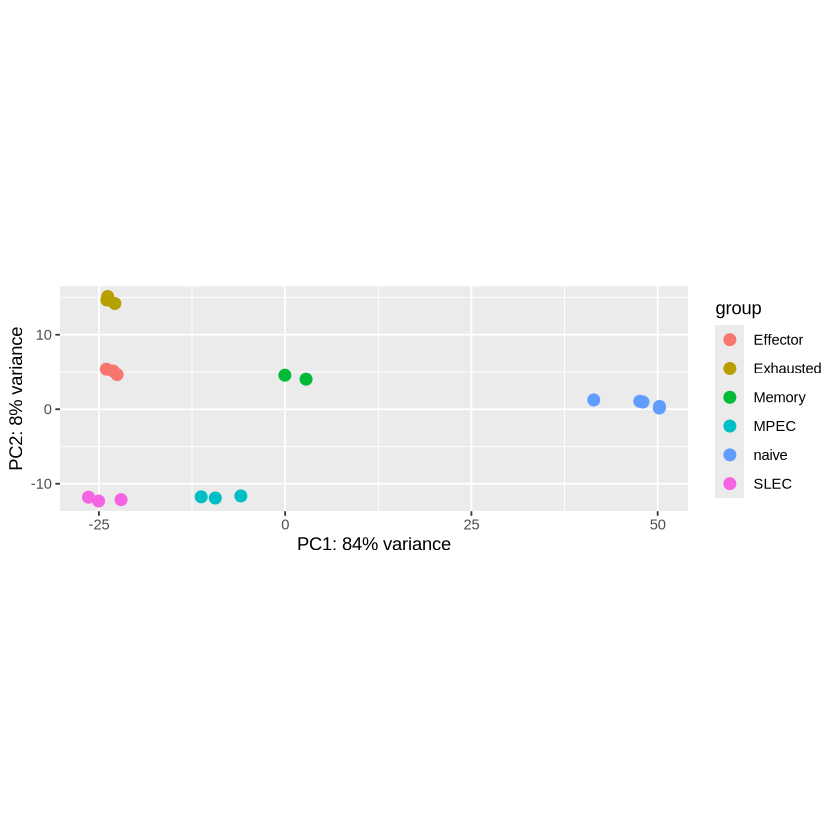

In [20]:
# Create DESeq object
dds <- DESeqDataSetFromMatrix(  countData = daExp,
                                colData   = daMeta,
                                design    = ~ Condition)

# Relevel dds so that naive samples are the reference
levels(colData(dds)$Condition)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))

## Perform Comparisons and Extract Results

In [21]:
# Load comparisons CSV
comparisons <- read.csv(comp_file)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  res <- lfcShrink( dds,
                    contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]),
                    type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(res),
    baseMean = res$baseMean,
    log2FC = res$log2FoldChange,
    statistic = stat$stat,
    pvalue = res$pvalue,
    padj = res$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(res, stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results <- bind_rows(results)

# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-DAPS.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(results, file = fn, row.names = FALSE)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/

## Count Differential Peaks

### p < 0.1

In [22]:
signif_counts <- function(results, padj_threshold = 0.1) {
    # Filter results for significant genes (padj < 0.1) and save into a new dataframe called "signif"
    signif <- results[results$padj < padj_threshold, ]

    # Create a new column named "direction" in signif and
    # assign "up" if log2FC > 0, "down" if log2FC < 0, and "no change" if log2FC = 0
    signif$direction <- ifelse(signif$log2FC > 0, "up", ifelse(signif$log2FC < 0, "down", "no change"))

    # Count the number of up and down peaks for each comparison in signif
    # Then spread the data to have separate columns for up and down counts
    counts <- signif %>%
    group_by(comparison, direction) %>%
    summarise(count = n()) %>%
    spread(direction, count)

    counts
}

signif_counts(results, padj_threshold = 0.1)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
Effector,17990,18404
Exhausted,17180,17662
Exhausted_vs_Effector,10446,9469
Exhausted_vs_Memory,11018,12570
Memory,11475,9762
Memory_vs_Effector,12864,11471
MPEC,17161,17032
SLEC,18041,18566
SLEC_vs_MPEC,6414,8965


### p < 0.05

In [23]:
signif_counts(results, padj_threshold = 0.05)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
Effector,17001,17471
Exhausted,16138,16633
Exhausted_vs_Effector,9034,7822
Exhausted_vs_Memory,9433,11201
Memory,9540,8629
Memory_vs_Effector,11308,9726
MPEC,16096,15927
SLEC,17092,17635
SLEC_vs_MPEC,5076,7413


## Define Peak Lists

Here, I define peak lists for Peak Set Enrichment Analysis (PSEA). First I create functions to do peak intersection.

In [24]:
# Create an empty list called peaks to store the dataframes
peaks <- list()

# Threshholds
pval = 0.05
log2FC = 1.5

# Load functions for peak intersection
source("00_scripts/define_peak_sets.R")

### Memory and Effector Peaks

Define memory-specific peaks as the intersection of [memory > naive] and [memory > effector] (Scott-Browne, 2016). Other comparisons follow this paradigm.

In [25]:
peaks$memory <- peak_intersector(   de_peaks = results,
                                    comp = c("Memory", "Memory_vs_Effector"),
                                    label = "jsb_memory",
                                    log2FC_adjuster = c(1, 1), pval_subset = pval, log2FC_subset = log2FC)

peaks$effector <- peak_intersector( de_peaks = results,
                                    comp = c("Effector", "Memory_vs_Effector"),
                                    label = "jsb_effector",
                                    log2FC_adjuster = c(1, -1), pval_subset = pval, log2FC_subset = log2FC)

peaks$slec <- peak_intersector( de_peaks = results,
                                comp = c("SLEC", "SLEC_vs_MPEC"),
                                label = "jsb_slec",
                                log2FC_adjuster = c(1, 1), pval_subset = pval, log2FC_subset = log2FC)

peaks$mpec <- peak_intersector( de_peaks = results,
                                comp = c("MPEC", "SLEC_vs_MPEC"),
                                label = "jsb_mpec",
                                log2FC_adjuster = c(1, -1), pval_subset = pval, log2FC_subset = log2FC)

peaks$naive <- peak_intersector(de_peaks = results,
                                comp = c("Effector", "Memory", "Exhausted", "SLEC", "MPEC"),
                                label = "jsb_naive",
                                log2FC_adjuster = c(-1, -1, -1, -1, -1), pval_subset = pval, log2FC_subset = log2FC)


# Combine all peak dataframes into a single dataframe
peaks <- bind_rows(peaks)
table(peaks$peak_set)


jsb_effector_closed   jsb_effector_open   jsb_memory_closed     jsb_memory_open 
               1053                1022                  21                  69 
    jsb_mpec_closed       jsb_mpec_open    jsb_naive_closed      jsb_naive_open 
                  4                  56                2278                2069 
    jsb_slec_closed       jsb_slec_open 
                481                 315 

### Exhaustion Peaks

Define exhaustion peaks as the intersection of [exhausted > naive], [exhausted > effector] and [exhausted > memory]. 

In [26]:
# Define exhaustion peaks:
exhaustion_peaks <- peak_intersector(
    de_peaks = results,
    comp = c("Exhausted", "Exhausted_vs_Memory", "Exhausted_vs_Effector"),
    label = "jsb_exhausted",
    log2FC_adjuster = c(1, 1, 1), pval_subset = pval, log2FC_subset = log2FC
)

table(exhaustion_peaks$peak_set)


jsb_exhausted_closed   jsb_exhausted_open 
                 470                  548 

### Combine Lists and Save

In [27]:
# Bind rows
peaks <- bind_rows(peaks, exhaustion_peaks)

# Check set counts
table(peaks$peak_set)


 jsb_effector_closed    jsb_effector_open jsb_exhausted_closed 
                1053                 1022                  470 
  jsb_exhausted_open    jsb_memory_closed      jsb_memory_open 
                 548                   21                   69 
     jsb_mpec_closed        jsb_mpec_open     jsb_naive_closed 
                   4                   56                 2278 
      jsb_naive_open      jsb_slec_closed        jsb_slec_open 
                2069                  481                  315 

In [28]:
# Format to Pipkin lab peak set specifications
# ps_name - peak set name
# peak_symbol - peak symbol
# Keep only ps_name and peak_symbol columns
peaks <- peaks %>%
    mutate( ps_name = peak_set,
            peak_symbol = name) %>%
    select(ps_name, peak_symbol)

head(peaks)

# Write the peaks sets into CSV
fn <- paste0(prefix, "-peakSets.csv")
fn <- paste0(nb_dir, "/peak_sets/", fn)
write.csv(peaks, file = fn, row.names = FALSE)

,ps_name,peak_symbol
,<chr>,<chr>
1,jsb_memory_open,Interval_194826
2,jsb_memory_open,Interval_92619
3,jsb_memory_open,Interval_92866
4,jsb_memory_open,Interval_213264
5,jsb_memory_open,Interval_125640
6,jsb_memory_open,Interval_133022
